# Proyecto Final - Big Data
**Estudiante: Justin Arce**

Este notebook contiene el pipeline completo (Fases 1-5) para el Problema #1: Predicción de la gravedad de accidentes de bicicleta en Madrid. El notebook está diseñado para ejecutarse de inicio a fin.

## Instalación de Dependencias y Configuración

In [2]:
# --- Importar Librerías ---
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from datetime import date
import time
import mlflow
from mlflow.tracking import MlflowClient

import pyspark

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType, StringType, DoubleType
from pyspark.sql.functions import col, expr, cast, concat_ws, lag, to_date, lit, substring, coalesce, when, regexp_replace, trim, udf, row_number

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, FeatureHasher, StandardScaler
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

/usr/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Comprobacion de Carga en BD

In [3]:
spark = SparkSession.builder \
    .appName("Proyecto") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()



ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/17 22:08:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
df_ml = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "dataset_final_ml") \
    .load()

In [5]:
spark.sparkContext.setLogLevel("ERROR")

In [6]:
df_ml.printSchema()

root
 |-- num_expediente: string (nullable = true)
 |-- accidente_grave: integer (nullable = true)
 |-- T_83_t=0: double (nullable = true)
 |-- VV_81_t=0: double (nullable = true)
 |-- P_89_t=0: double (nullable = true)
 |-- T_83_t-1h: double (nullable = true)
 |-- VV_81_t-1h: double (nullable = true)
 |-- P_89_t-1h: double (nullable = true)
 |-- T_83_t-2h: double (nullable = true)
 |-- VV_81_t-2h: double (nullable = true)
 |-- P_89_t-2h: double (nullable = true)
 |-- hora: string (nullable = true)
 |-- tipo_accidente: string (nullable = true)
 |-- distrito: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- estado_meteorológico: string (nullable = true)
 |-- positiva_alcohol: string (nullable = true)
 |-- positiva_droga: string (nullable = true)
 |-- tipo_persona: string (nullable = true)



In [7]:
df_ml.show(5)

+--------------+---------------+--------+---------+--------+---------+----------+---------+---------+----------+---------+----+--------------------+-------------------+------+--------------------+----------------+--------------+------------+
|num_expediente|accidente_grave|T_83_t=0|VV_81_t=0|P_89_t=0|T_83_t-1h|VV_81_t-1h|P_89_t-1h|T_83_t-2h|VV_81_t-2h|P_89_t-2h|hora|      tipo_accidente|           distrito|  sexo|estado_meteorológico|positiva_alcohol|positiva_droga|tipo_persona|
+--------------+---------------+--------+---------+--------+---------+----------+---------+---------+----------+---------+----+--------------------+-------------------+------+--------------------+----------------+--------------+------------+
|   2019S002594|              0|    -1.3|      0.0|     0.0|     -0.1|       0.0|      0.0|      1.9|       0.0|      0.0| H22|Choque contra obs...|             LATINA|Hombre|           Despejado|               N|          NULL|   Conductor|
|   2019S006584|              0|

## Fase 3: EDA (Pre-Experimento)

**Objetivo:** Analizar el dataset limpio (`df_final_ml`) antes de entrenar.

In [8]:
#seed para reproducibilidad
SEED = 101

In [9]:
# --- EJECUTAR FASE 3 ---
print("\n--- INICIANDO FASE 3: ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---")

# 1. Análisis de Variable Objetivo (sensibilidad a clases)
print("Análisis de Desbalanceo:")
df_ml.groupBy('accidente_grave').count().show()

# 2. Análisis de Predictores Numéricos (histogramas, boxplots, matriz)
numeric_cols_to_plot = [c for c in df_ml.columns if c.startswith(('T_', 'VV_', 'P_'))]
df_sample_pd = df_ml.select(['accidente_grave'] + numeric_cols_to_plot).sample(fraction=0.1, seed=SEED).toPandas()


--- INICIANDO FASE 3: ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---
Análisis de Desbalanceo:
+---------------+-----+
|accidente_grave|count|
+---------------+-----+
|              1|  160|
|              0| 4487|
+---------------+-----+



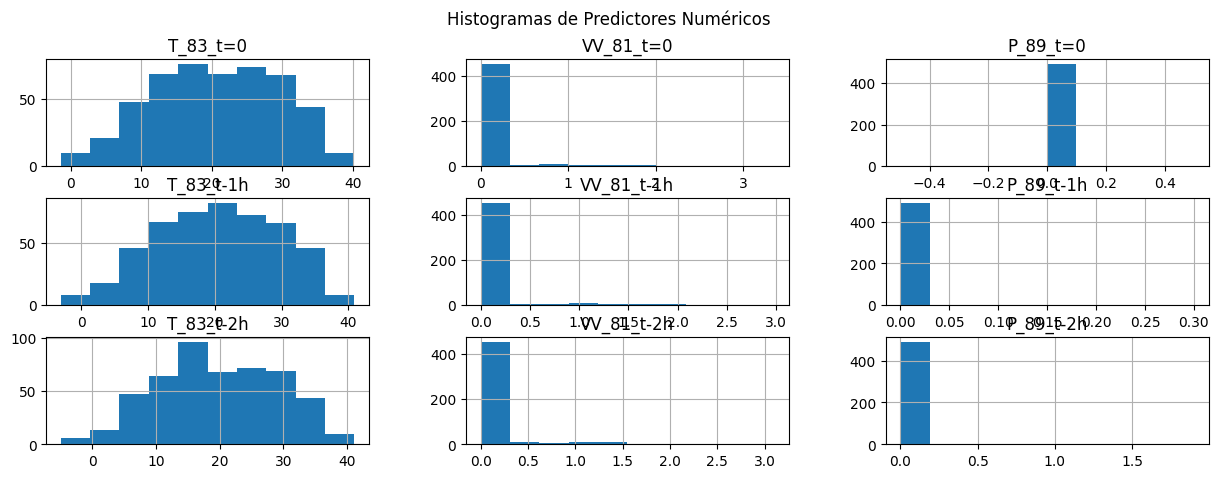

In [10]:
# Histogramas
df_sample_pd[numeric_cols_to_plot].hist(figsize=(15, 5))
plt.suptitle("Histogramas de Predictores Numéricos")
plt.show()

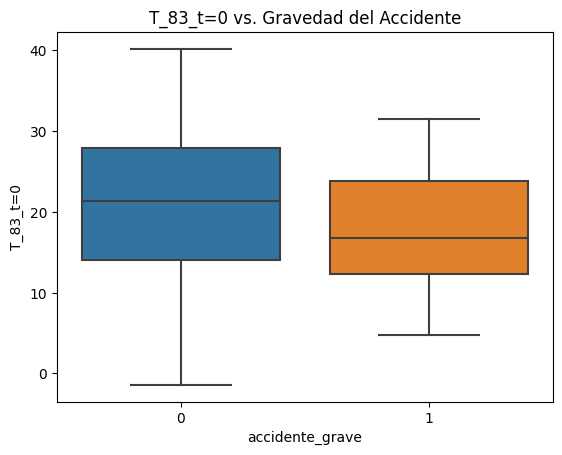

In [11]:
# Boxplots Bivariados
sns.boxplot(data=df_sample_pd, x='accidente_grave', y=numeric_cols_to_plot[0])
plt.title(f"{numeric_cols_to_plot[0]} vs. Gravedad del Accidente")
plt.show()

In [12]:
# 3. Dividir Datos (Split) para Experimento
training_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=SEED)
training_data.cache()
test_data.cache()
print(f"Datos divididos: {training_data.count()} para entrenamiento, {test_data.count()} para prueba final.")

print(f"\n--- FASE 3 COMPLETADA ---")

Datos divididos: 3706 para entrenamiento, 941 para prueba final.

--- FASE 3 COMPLETADA ---


<AxesSubplot:>

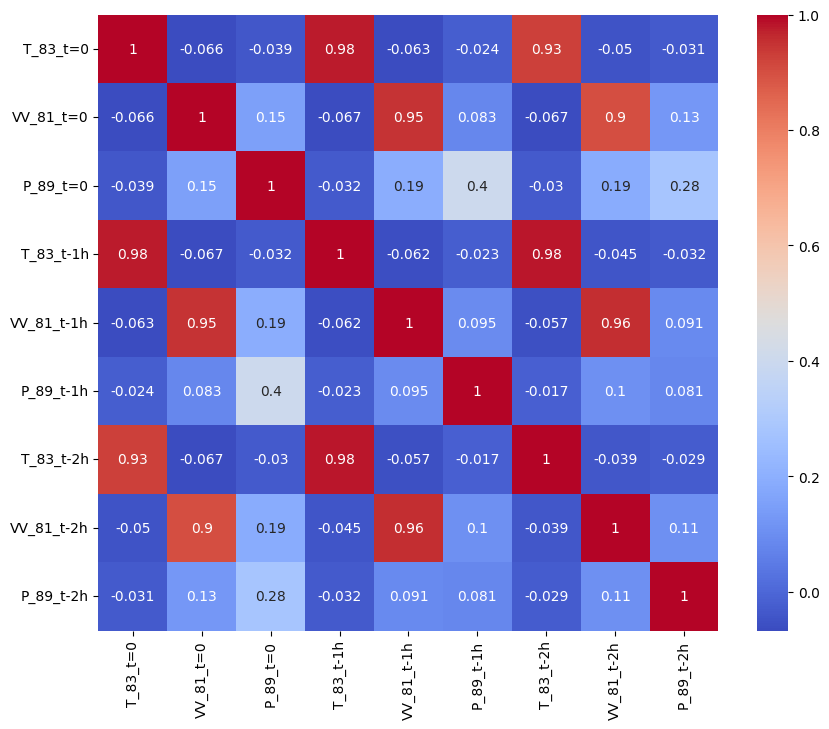

In [41]:
# Matriz de correlación
numeric_cols = [c for c in df_ml.columns if c.startswith(('T_', 'VV_', 'P_'))]
corr_matrix = df_ml.select(numeric_cols).toPandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Fase 4: Experimento Robusto (DOE)

**Objetivo:** Ejecutar el plan "Robusto Ultra-Eficiente" (18 corridas) y guardar los resultados.

In [38]:
# --- Funciones de Fase 4 (Experimento) (CORREGIDAS) ---


# Esto rompe la dependencia circular
label_converter = col("accidente_grave").cast(DoubleType()).alias("label")


def construir_pipeline(modelo, factor_b, factor_c):
    """
    Construye el pipeline de Spark ML (CORREGIDO).
    Asume que 'label_converter' y 'classWeight' se manejan FUERA de esta función.
    """

    # Features Numéricas Fijas (Solo t=0)
    numeric_features = ["T_83_t=0", "VV_81_t=0", "P_89_t=0"]
    categorical_features = ["tipo_accidente", "distrito", "sexo", "estado_meteorológico"]

    stages = []

    # Factor C: Estrategia Categórica
    feature_cols = list(numeric_features)

    if factor_c == "Drop":
        pass # No se añaden features categóricas
    elif factor_c == "OHE":
        indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_features]
        encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec") for c in categorical_features]
        stages += indexers + encoders
        feature_cols += [f"{c}_vec" for c in categorical_features]

    # Ensamblador final
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled", handleInvalid="skip")
    stages.append(assembler)

    # --- Lógica Acoplada (Normalización) ---
    input_features_col = "features_unscaled"
    if modelo == "LR":
        scaler = StandardScaler(inputCol="features_unscaled", outputCol="features_scaled")
        stages.append(scaler)
        input_features_col = "features_scaled"

    # --- Modelo (Factor A) ---
    model_instance = None
    if modelo == "LR":
        model_instance = LogisticRegression(featuresCol=input_features_col, labelCol="label")
        # --- CORRECCIÓN: Configurar 'weightCol' si Factor B es 'Weights' ---
        if factor_b == "Weights":
            model_instance.setWeightCol("classWeight")

    elif modelo == "GBT":
        model_instance = GBTClassifier(featuresCol=input_features_col, labelCol="label", seed=SEED)
        # --- CORRECCIÓN: Configurar 'weightCol' si Factor B es 'Weights' ---
        if factor_b == "Weights":
            model_instance.setWeightCol("classWeight")

    stages.append(model_instance)

    return Pipeline(stages=stages), model_instance


def ejecutar_hpo(spark, training_data_with_label, pipeline, model, modelo_str, trials=3):
    """
    Etapa A: HPO Ultra-Ligera (5 trials, K=3)
    """
    evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR", labelCol="label")

    def objective(trial):
        param_map = {}
        if modelo_str == "LR":
            regParam = trial.suggest_loguniform("regParam", 1e-4, 1.0)
            elasticNetParam = trial.suggest_uniform("elasticNetParam", 0.0, 1.0)
            param_map[model.regParam] = regParam
            param_map[model.elasticNetParam] = elasticNetParam
        elif modelo_str == "GBT":
            maxDepth = trial.suggest_int("maxDepth", 2, 7)
            maxIter = trial.suggest_int("maxIter", 10, 25)
            param_map[model.maxDepth] = maxDepth
            param_map[model.maxIter] = maxIter

        cv = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=[param_map],
            evaluator=evaluator,
            numFolds=3, # K-Fold=3
            seed=SEED
        )

        # (Asegurarse de que training_data_with_label esté cacheado)
        cv_model = cv.fit(training_data_with_label)
        return cv_model.avgMetrics[0] # Maximizar AUC-PR

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials) # 5 trials

    # Devolver un dict {str: val}
    return study.best_params


def medir_robustez(spark, training_data_with_label, pipeline, best_params_str):
    """
    Etapa B: Medición S/N (K=3, Seed Fija)
    """
    evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR", labelCol="label")

    model_stage = pipeline.getStages()[-1]
    param_grid = ParamGridBuilder()

    if best_params_str: # best_params_str es un dict {str: val}
        for param_name, value in best_params_str.items():
            spark_param = model_stage.getParam(param_name)
            param_grid = param_grid.addGrid(spark_param, [value])

    param_map = param_grid.build()

    if not param_map:
        param_map = [{}]

    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_map,
        evaluator=evaluator,
        numFolds=3, # K-Fold=3
        seed=SEED,  # Semilla Fija
        collectSubModels=False
    )

    cv_model = cv.fit(training_data_with_label)

    metrics = cv_model.avgMetrics

    metrics_array = np.array(metrics)
    metrics_array[metrics_array <= 0] = 1e-9

    sn_ratio = -10 * np.log10(np.mean(1 / (metrics_array**2)))

    return sn_ratio, metrics

In [14]:
start_time = time.time()
print("\n--- INICIANDO FASE 4: EJECUCIÓN DEL EXPERIMENTO (B x C simplificado + MLflow Local) ---")

# --- 1. Configuración de MLflow (LOCAL) ---
EXPERIMENT_NAME = "Proyecto_Accidentes_DOE_Local"
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"Registrando corridas localmente en la carpeta 'mlruns/' (Experimento: '{EXPERIMENT_NAME}')")

# --- 2. Definición del Diseño Experimental (12 Corridas) ---
MODELOS = ["LR", "GBT"]
# --- CAMBIO: Se reemplaza 'None' por 'ROS' ---
DESBALANCEO = ["Weights", "RUS", "ROS"] # Factor B (3 Niveles)
CATEGORICA = ["Drop", "OHE"]             # Factor C (2 Niveles - Hasher eliminado)
D_VAL_FIJO = "t=0"                       # Factor D (Fijo)

# Diseño Factorial Completo (3x2 = 6 corridas por modelo)
DESIGN = [
  (0, 0), (0, 1), # B=Weights con C=Drop, OHE
  (1, 0), (1, 1), # B=RUS     con C=Drop, OHE
  (2, 0), (2, 1)  # B=ROS     con C=Drop, OHE  <--- CAMBIO EN EL COMENTARIO
]

# --- 3. Preparación de Datos Base (Fuera del bucle) ---
# (label_converter está definido en la celda anterior)
training_data_with_label = training_data.select("*", label_converter)
training_data_with_label.cache()
print(f"Datos de entrenamiento preparados (con 'label'): {training_data_with_label.count()} filas")


# --- 4. Bucle de Ejecución del Experimento ---
resultados_doe = [] # Lista de respaldo

for MODELO in MODELOS:
    print(f"\n--- INICIANDO TORNEO PARA MODELO: {MODELO} ---")

    for i, (b_idx, c_idx) in enumerate(DESIGN):
        run_id = i + 1
        B_VAL = DESBALANCEO[b_idx]
        C_VAL = CATEGORICA[c_idx]

        run_name = f"run_{MODELO}_B{b_idx+1}_C{c_idx+1}"
        print(f"\n==> Ejecutando Run {run_id}/6 para {MODELO}: B={B_VAL}, C={C_VAL} <==")

        # Iniciar corrida de MLflow
        with mlflow.start_run(run_name=run_name) as run:
            try:
                # Registrar Parámetros
                mlflow.log_param("modelo", MODELO)
                mlflow.log_param("desbalanceo", B_VAL)
                mlflow.log_param("categorica", C_VAL)
                mlflow.log_param("temporal", D_VAL_FIJO)

                # --- CORRECCIÓN DE ORDEN ---

                # 1. Aplicar lógica de Desbalanceo (Factor B)
                training_data_run = training_data_with_label # Empezar con el DF base

                if B_VAL == "RUS":
                    print("   -> Aplicando RUS...")
                    major_df = training_data_run.filter(col("label") == 0)
                    minor_df = training_data_run.filter(col("label") == 1)
                    count_major = major_df.count(); count_minor = minor_df.count()

                    if count_major > 0 and count_minor > 0:
                        ratio = (count_minor / count_major) * 1.1
                        if ratio > 1.0: ratio = 1.0
                        major_sampled = major_df.sample(False, ratio, seed=SEED)
                        training_data_run = major_sampled.unionAll(minor_df)
                        print(f"   -> RUS Aplicado. Nuevo tamaño: {training_data_run.count()}")
                    else: print("   -> Advertencia: RUS omitido.")

                elif B_VAL == "Weights":
                    print("   -> Calculando 'classWeights'...")
                    counts = training_data_run.groupBy("label").count().collect()
                    count_0 = next((row['count'] for row in counts if row['label'] == 0.0), 0)
                    count_1 = next((row['count'] for row in counts if row['label'] == 1.0), 0)

                    if count_0 > 0 and count_1 > 0:
                        total = count_0 + count_1
                        w0 = total / (2.0 * count_0); w1 = total / (2.0 * count_1)
                        training_data_run = training_data_run.withColumn(
                            "classWeight", when(col("label") == 0.0, w0).otherwise(w1)
                        )
                        print(f"   -> Weights Aplicados: w0={w0:.2f}, w1={w1:.2f}")
                    else: print("   -> Advertencia: 'Weights' omitido.")

                # --- INICIO: LÓGICA DE ROS (NUEVO BLOQUE) ---
                elif B_VAL == "ROS":
                    print("   -> Aplicando ROS (Random Over-Sampling)...")
                    major_df = training_data_run.filter(col("label") == 0)
                    minor_df = training_data_run.filter(col("label") == 1)

                    # Cachear para eficiencia en los .count()
                    major_df.cache()
                    minor_df.cache()

                    count_major = major_df.count()
                    count_minor = minor_df.count()

                    if count_major > 0 and count_minor > 0 and count_major > count_minor:
                        ratio = count_major / count_minor
                        print(f"   -> Ratio: {ratio:.2f} (Major: {count_major}, Minor: {count_minor})")

                        # Muestrear la clase minoritaria CON reemplazo
                        minor_oversampled = minor_df.sample(withReplacement=True, fraction=ratio, seed=SEED)

                        # Unir la clase mayoritaria original con la minoritaria sobremuestreada
                        training_data_run = major_df.unionAll(minor_oversampled)
                        print(f"   -> ROS Aplicado. Nuevo tamaño: {training_data_run.count()}")

                    elif count_minor == 0:
                        print("   -> ADVERTENCIA: ROS omitido (no hay muestras de clase minoritaria).")
                    elif count_major == 0:
                         print("   -> ADVERTENCIA: ROS omitido (no hay muestras de clase mayoritaria).")
                    else: # count_major <= count_minor
                         print(f"   -> INFO: ROS omitido (datos ya balanceados o minoría > mayoría).")

                    # Limpiar cache
                    major_df.unpersist()
                    minor_df.unpersist()
                # --- FIN: LÓGICA DE ROS ---

                # (Si B_VAL == "None", no hacíamos nada. Ahora ROS ocupa ese lugar)

                # 2. Construir pipeline (Ahora con los datos correctos)
                # (construir_pipeline está definida en la celda anterior)
                pipeline, model_instance = construir_pipeline(MODELO, B_VAL, C_VAL)

                # 3. Etapa A: HPO (Optimización)
                print("   -> Etapa A: HPO (3 trials)...")
                try:
                    best_params_str = ejecutar_hpo(spark, training_data_run, pipeline, model_instance, MODELO)
                except Exception as e:
                    print(f"       Advertencia HPO (usando defaults): {e}")
                    best_params_str = {}

                mlflow.log_params(best_params_str)

                # 4. Etapa B: Medición S/N (Robustez)
                print("   -> Etapa B: S/N (3 folds)...")
                pipeline_sn, _ = construir_pipeline(MODELO, B_VAL, C_VAL)

                sn_ratio, fold_metrics = medir_robustez(spark, training_data_run, pipeline_sn, best_params_str)

                # 5. Registrar Métricas
                print(f"   -> S/N Ratio: {sn_ratio:.4f}")
                mlflow.log_metric("sn_ratio_lb", sn_ratio)
                if len(fold_metrics) >= 3:
                    mlflow.log_metric("auc_pr_fold1", fold_metrics[0])
                    mlflow.log_metric("auc_pr_fold2", fold_metrics[1])
                    mlflow.log_metric("auc_pr_fold3", fold_metrics[2])

                # Guardar en lista de respaldo
                resultados_doe.append({
                    "run_id": run.info.run_id, "modelo": MODELO, "desbalanceo": B_VAL,
                    "categorica": C_VAL, "sn_ratio": sn_ratio, "status": "SUCCESS",
                    "best_params": best_params_str
                })
                mlflow.set_tag("status", "SUCCESS")

            except Exception as e:
                print(f"ERROR CRÍTICO en la corrida {run_name}: {e}")
                mlflow.set_tag("status", "FAILED")
                # Registrar en respaldo
                resultados_doe.append({
                    "run_id": run.info.run_id if 'run' in locals() and run else "N/A",
                    "modelo": MODELO, "desbalanceo": B_VAL,
                    "categorica": C_VAL, "sn_ratio": np.nan, "status": "FAILED",
                    "best_params": {}
                })

# Descachear el DF base
training_data_with_label.unpersist()

print(f"\n--- FASE 4 COMPLETADA en {time.time() - start_time:.2f} segundos ---")
df_resultados_backup = pd.DataFrame(resultados_doe)


--- INICIANDO FASE 4: EJECUCIÓN DEL EXPERIMENTO (B x C simplificado + MLflow Local) ---
Registrando corridas localmente en la carpeta 'mlruns/' (Experimento: 'Proyecto_Accidentes_DOE_Local')


2025/11/17 22:08:38 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Datos de entrenamiento preparados (con 'label'): 3706 filas

--- INICIANDO TORNEO PARA MODELO: LR ---

==> Ejecutando Run 1/6 para LR: B=Weights, C=Drop <==
   -> Calculando 'classWeights'...


[I 2025-11-17 22:08:38,890] A new study created in memory with name: no-name-506cc57e-7ec6-494b-97b5-c439218cfbb5


   -> Weights Aplicados: w0=0.52, w1=14.15
   -> Etapa A: HPO (3 trials)...


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-11-17 22:08:50,006] Trial 0 finished with value: 0.04719555569441933 and parameters: {'regParam': 0.0015909023577597896, 'elasticNetParam': 0.45703743912664785}. Best is trial 0 with value: 0.04719555569441933.
[I 2025-11-17 22:08:52,826] Trial 1 finished with value: 0.03482969697313503 and parameters: {'regParam': 0.07985540283268894, 'elasticNetParam': 0.41826359404052815}. Best is trial 0 with value: 0.04719555569441933.
[I 2025-11-17 22:08:56,227] Trial 2 finished with valu

   -> Etapa B: S/N (3 folds)...


[I 2025-11-17 22:09:00,231] A new study created in memory with name: no-name-03d1325e-0b26-4064-8aed-3640d5e956aa


   -> S/N Ratio: -26.5220

==> Ejecutando Run 2/6 para LR: B=Weights, C=OHE <==
   -> Calculando 'classWeights'...
   -> Weights Aplicados: w0=0.52, w1=14.15
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:09:09,112] Trial 0 finished with value: 0.039058912271867814 and parameters: {'regParam': 0.027137286738058576, 'elasticNetParam': 0.6179770330696523}. Best is trial 0 with value: 0.039058912271867814.
[I 2025-11-17 22:09:26,344] Trial 1 finished with value: 0.039356997969415775 and parameters: {'regParam': 0.0020670759768270197, 'elasticNetParam': 0.8294068922645073}. Best is trial 1 with value: 0.039356997969415775.
[I 2025-11-17 22:09:36,043] Trial 2 finished with value: 0.03934934236307206 and parameters: {'regParam': 0.005828728506425312, 'elasticNetParam': 0.14087239054808887}. Best is trial 1 with value: 0.039356997969415775.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -28.0996

==> Ejecutando Run 3/6 para LR: B=RUS, C=Drop <==
   -> Aplicando RUS...


[I 2025-11-17 22:09:55,763] A new study created in memory with name: no-name-9b689f1f-713b-48ba-b25c-aa381a8fa29d


   -> RUS Aplicado. Nuevo tamaño: 302
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:10:00,428] Trial 0 finished with value: 0.4291184477311936 and parameters: {'regParam': 0.24037488157895456, 'elasticNetParam': 0.20299089369236956}. Best is trial 0 with value: 0.4291184477311936.
[I 2025-11-17 22:10:06,214] Trial 1 finished with value: 0.4073200058659656 and parameters: {'regParam': 0.0008553032045966715, 'elasticNetParam': 0.6035697637237619}. Best is trial 0 with value: 0.4291184477311936.
[I 2025-11-17 22:10:09,433] Trial 2 finished with value: 0.4077304922641906 and parameters: {'regParam': 0.017544551951759125, 'elasticNetParam': 0.20866572735923083}. Best is trial 0 with value: 0.4291184477311936.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -7.3485

==> Ejecutando Run 4/6 para LR: B=RUS, C=OHE <==
   -> Aplicando RUS...


[I 2025-11-17 22:10:11,948] A new study created in memory with name: no-name-4a0b5ce1-74f0-43f8-ac26-a6cbebddb72f


   -> RUS Aplicado. Nuevo tamaño: 302
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:10:18,731] Trial 0 finished with value: 0.4318862865280619 and parameters: {'regParam': 0.04472305985059721, 'elasticNetParam': 0.32111719221401613}. Best is trial 0 with value: 0.4318862865280619.
[I 2025-11-17 22:10:29,996] Trial 1 finished with value: 0.4320094348387718 and parameters: {'regParam': 0.022853413416622656, 'elasticNetParam': 0.6991776049042872}. Best is trial 1 with value: 0.4320094348387718.
[I 2025-11-17 22:10:40,998] Trial 2 finished with value: 0.4253687428504513 and parameters: {'regParam': 0.015378908505395349, 'elasticNetParam': 0.8635531139734139}. Best is trial 1 with value: 0.4320094348387718.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -7.2901

==> Ejecutando Run 5/6 para LR: B=ROS, C=Drop <==
   -> Aplicando ROS (Random Over-Sampling)...


[I 2025-11-17 22:10:51,753] A new study created in memory with name: no-name-3e05fe90-b702-437c-9cfc-46a6f6944dcc


   -> Ratio: 27.29 (Major: 3575, Minor: 131)
   -> ROS Aplicado. Nuevo tamaño: 7101
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:10:56,446] Trial 0 finished with value: 0.5468764826805144 and parameters: {'regParam': 0.00024393568261764844, 'elasticNetParam': 0.915091831361305}. Best is trial 0 with value: 0.5468764826805144.
[I 2025-11-17 22:11:03,251] Trial 1 finished with value: 0.5468577459173 and parameters: {'regParam': 0.00013356202813099373, 'elasticNetParam': 0.47745264156680833}. Best is trial 0 with value: 0.5468764826805144.
[I 2025-11-17 22:11:06,647] Trial 2 finished with value: 0.545087090907668 and parameters: {'regParam': 0.038038857589594494, 'elasticNetParam': 0.07134415560645002}. Best is trial 0 with value: 0.5468764826805144.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -5.2422

==> Ejecutando Run 6/6 para LR: B=ROS, C=OHE <==
   -> Aplicando ROS (Random Over-Sampling)...


[I 2025-11-17 22:11:11,383] A new study created in memory with name: no-name-571a7834-a009-4d5b-8e22-515049591088


   -> Ratio: 27.29 (Major: 3575, Minor: 131)
   -> ROS Aplicado. Nuevo tamaño: 7101
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:11:28,640] Trial 0 finished with value: 0.6383672856865601 and parameters: {'regParam': 0.0010747834188329923, 'elasticNetParam': 0.6429430793037029}. Best is trial 0 with value: 0.6383672856865601.
[I 2025-11-17 22:11:38,285] Trial 1 finished with value: 0.6228615011367445 and parameters: {'regParam': 0.06789537851137813, 'elasticNetParam': 0.25942228984443094}. Best is trial 0 with value: 0.6383672856865601.
[I 2025-11-17 22:11:50,040] Trial 2 finished with value: 0.638232166334158 and parameters: {'regParam': 0.0117252356908406, 'elasticNetParam': 0.3393899960405966}. Best is trial 0 with value: 0.6383672856865601.


   -> Etapa B: S/N (3 folds)...


[I 2025-11-17 22:12:08,750] A new study created in memory with name: no-name-bfbb2a09-59ae-4600-b689-b9fa2a360070


   -> S/N Ratio: -3.8986

--- INICIANDO TORNEO PARA MODELO: GBT ---

==> Ejecutando Run 1/6 para GBT: B=Weights, C=Drop <==
   -> Calculando 'classWeights'...
   -> Weights Aplicados: w0=0.52, w1=14.15
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:12:19,306] Trial 0 finished with value: 0.0323249179098588 and parameters: {'maxDepth': 3, 'maxIter': 16}. Best is trial 0 with value: 0.0323249179098588.
[I 2025-11-17 22:12:40,715] Trial 1 finished with value: 0.03479194935279536 and parameters: {'maxDepth': 7, 'maxIter': 16}. Best is trial 1 with value: 0.03479194935279536.
[I 2025-11-17 22:12:50,353] Trial 2 finished with value: 0.03625918240067011 and parameters: {'maxDepth': 2, 'maxIter': 23}. Best is trial 2 with value: 0.03625918240067011.


   -> Etapa B: S/N (3 folds)...


[I 2025-11-17 22:13:01,890] A new study created in memory with name: no-name-c8f492c8-a397-4fe8-8c9b-6c1907186d55


   -> S/N Ratio: -28.8116

==> Ejecutando Run 2/6 para GBT: B=Weights, C=OHE <==
   -> Calculando 'classWeights'...
   -> Weights Aplicados: w0=0.52, w1=14.15
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:13:21,158] Trial 0 finished with value: 0.04210245818364485 and parameters: {'maxDepth': 6, 'maxIter': 10}. Best is trial 0 with value: 0.04210245818364485.
[I 2025-11-17 22:13:33,331] Trial 1 finished with value: 0.04090729187542554 and parameters: {'maxDepth': 4, 'maxIter': 11}. Best is trial 0 with value: 0.04210245818364485.
[I 2025-11-17 22:13:54,441] Trial 2 finished with value: 0.03749788016515199 and parameters: {'maxDepth': 4, 'maxIter': 24}. Best is trial 0 with value: 0.04210245818364485.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -27.5139

==> Ejecutando Run 3/6 para GBT: B=RUS, C=Drop <==
   -> Aplicando RUS...


[I 2025-11-17 22:14:09,067] A new study created in memory with name: no-name-35efff32-6491-4325-b9d3-154545d6d99e


   -> RUS Aplicado. Nuevo tamaño: 302
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:14:24,162] Trial 0 finished with value: 0.43771082900118313 and parameters: {'maxDepth': 6, 'maxIter': 12}. Best is trial 0 with value: 0.43771082900118313.
[I 2025-11-17 22:14:38,936] Trial 1 finished with value: 0.4255224673270526 and parameters: {'maxDepth': 5, 'maxIter': 20}. Best is trial 0 with value: 0.43771082900118313.
[I 2025-11-17 22:14:53,461] Trial 2 finished with value: 0.4261058034414931 and parameters: {'maxDepth': 4, 'maxIter': 23}. Best is trial 0 with value: 0.43771082900118313.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -7.1763

==> Ejecutando Run 4/6 para GBT: B=RUS, C=OHE <==
   -> Aplicando RUS...


[I 2025-11-17 22:15:04,607] A new study created in memory with name: no-name-0dd93d56-96e5-4bec-b4ae-6397ad7a4ec3


   -> RUS Aplicado. Nuevo tamaño: 302
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:15:14,102] Trial 0 finished with value: 0.4111374254955824 and parameters: {'maxDepth': 2, 'maxIter': 13}. Best is trial 0 with value: 0.4111374254955824.
[I 2025-11-17 22:15:28,828] Trial 1 finished with value: 0.39757796905121506 and parameters: {'maxDepth': 3, 'maxIter': 12}. Best is trial 0 with value: 0.4111374254955824.
[I 2025-11-17 22:15:37,878] Trial 2 finished with value: 0.4164371904299526 and parameters: {'maxDepth': 2, 'maxIter': 10}. Best is trial 2 with value: 0.4164371904299526.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -7.6090

==> Ejecutando Run 5/6 para GBT: B=ROS, C=Drop <==
   -> Aplicando ROS (Random Over-Sampling)...
   -> Ratio: 27.29 (Major: 3575, Minor: 131)


[I 2025-11-17 22:15:44,681] A new study created in memory with name: no-name-ee0b6f7d-22cf-414e-9515-12c4a368d982


   -> ROS Aplicado. Nuevo tamaño: 7101
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:15:56,757] Trial 0 finished with value: 0.6359440848149985 and parameters: {'maxDepth': 3, 'maxIter': 18}. Best is trial 0 with value: 0.6359440848149985.
[I 2025-11-17 22:16:03,868] Trial 1 finished with value: 0.6075991926855734 and parameters: {'maxDepth': 2, 'maxIter': 16}. Best is trial 0 with value: 0.6359440848149985.
[I 2025-11-17 22:16:29,421] Trial 2 finished with value: 0.6777946786889206 and parameters: {'maxDepth': 7, 'maxIter': 18}. Best is trial 2 with value: 0.6777946786889206.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -3.3780

==> Ejecutando Run 6/6 para GBT: B=ROS, C=OHE <==
   -> Aplicando ROS (Random Over-Sampling)...
   -> Ratio: 27.29 (Major: 3575, Minor: 131)


[I 2025-11-17 22:16:52,215] A new study created in memory with name: no-name-8ad5882a-1d62-4ae7-8710-81c4f80bf45a


   -> ROS Aplicado. Nuevo tamaño: 7101
   -> Etapa A: HPO (3 trials)...


[I 2025-11-17 22:17:08,244] Trial 0 finished with value: 0.673500957251188 and parameters: {'maxDepth': 2, 'maxIter': 25}. Best is trial 0 with value: 0.673500957251188.
[I 2025-11-17 22:17:24,443] Trial 1 finished with value: 0.72074416889659 and parameters: {'maxDepth': 3, 'maxIter': 21}. Best is trial 1 with value: 0.72074416889659.
[I 2025-11-17 22:17:47,532] Trial 2 finished with value: 0.8748934418183109 and parameters: {'maxDepth': 6, 'maxIter': 17}. Best is trial 2 with value: 0.8748934418183109.


   -> Etapa B: S/N (3 folds)...
   -> S/N Ratio: -1.1609

--- FASE 4 COMPLETADA en 574.58 segundos ---


## Fase 5: Análisis de Resultados y Duelo Final

**Objetivo:** Analizar los S/N Ratios, seleccionar los dos campeones y enfrentarlos en el `test_data`.

In [25]:
# --- EJECUTAR FASE 5 (ADAPTADA: MLflow Local + RUS Logic) ---
print("\n--- INICIANDO FASE 5: ANÁLISIS Y DUELO FINAL (desde MLflow) ---")

# 1. Cargar resultados del experimento desde MLflow
try:
    exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    runs_df = mlflow.search_runs(experiment_ids=[exp.experiment_id])
    runs_df = runs_df[runs_df["tags.status"] == "SUCCESS"]
    cols_to_keep = [
        "run_id", "metrics.sn_ratio_lb", "params.modelo", "params.desbalanceo",
        "params.categorica", "params.maxDepth", "params.maxIter",
        "params.regParam", "params.elasticNetParam"
    ]
    cols_exist = [col for col in cols_to_keep if col in runs_df.columns]
    results_df = runs_df[cols_exist].dropna(subset=["metrics.sn_ratio_lb"])
    results_df.rename(columns={"metrics.sn_ratio_lb": "sn_ratio"}, inplace=True)
    print(f"Se cargaron {len(results_df)} corridas exitosas desde MLflow.")
except Exception as e:
    print(f"Error al cargar datos de MLflow: {e}")
    print("Usando backup de la celda anterior...")

    # Si MLflow falla, usamos el backup y RENOMBRAMOS las columnas
    # para que coincidan con el schema de MLflow (params.modelo, etc.)
    if 'df_resultados_backup' in locals() and not df_resultados_backup.empty:
        results_df = df_resultados_backup.rename(columns={
            "run_id_mlflow": "run_id",
            "modelo": "params.modelo",
            "desbalanceo": "params.desbalanceo",
            "categorica": "params.categorica",
            "sn_ratio": "sn_ratio"
        })

        # Añadir columnas de HPO faltantes como NaN para evitar KeyErrors después
        if "params.regParam" not in results_df.columns:
            results_df["params.regParam"] = pd.NA
        if "params.elasticNetParam" not in results_df.columns:
            results_df["params.elasticNetParam"] = pd.NA
        if "params.maxDepth" not in results_df.columns:
            results_df["params.maxDepth"] = pd.NA
        if "params.maxIter" not in results_df.columns:
            results_df["params.maxIter"] = pd.NA

        print(f"Backup cargado y renombrado con {len(results_df)} corridas.")
    else:
        print("Error: No hay datos de MLflow Y no hay backup. Abortando.")
        results_df = pd.DataFrame()




--- INICIANDO FASE 5: ANÁLISIS Y DUELO FINAL (desde MLflow) ---
Se cargaron 21 corridas exitosas desde MLflow.


In [16]:

# Función para graficar efectos
def plot_efectos(df, modelo_nombre):
    if df.empty: return
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.pointplot(data=df, x="params.desbalanceo", y="sn_ratio", ax=axes[0], order=DESBALANCEO).set_title(f"Factor B (Desbalanceo) - {modelo_nombre}")
    sns.pointplot(data=df, x="params.categorica", y="sn_ratio", ax=axes[1], order=CATEGORICA).set_title(f"Factor C (Categórica) - {modelo_nombre}")
    plt.suptitle(f"Gráficos de Efectos Principales (S/N Ratio) - {modelo_nombre}", fontsize=16)
    plt.show()




--- Resultados Torneo LR ---
|   sn_ratio | params.desbalanceo   | params.categorica   |
|-----------:|:---------------------|:--------------------|
|   -3.89859 | ROS                  | OHE                 |
|   -5.24222 | ROS                  | Drop                |
|   -7.29014 | RUS                  | OHE                 |
|   -7.31986 | RUS                  | OHE                 |
|   -7.31986 | RUS                  | Drop                |
|   -7.34846 | RUS                  | Drop                |
|  -26.5067  | Weights              | Drop                |
|  -26.5067  | Weights              | Drop                |
|  -26.5108  | Weights              | Drop                |
|  -26.522   | Weights              | Drop                |
|  -26.8598  | None                 | Drop                |
|  -27.9002  | None                 | OHE                 |
|  -28.0437  | Weights              | OHE                 |
|  -28.0996  | Weights              | OHE                 |


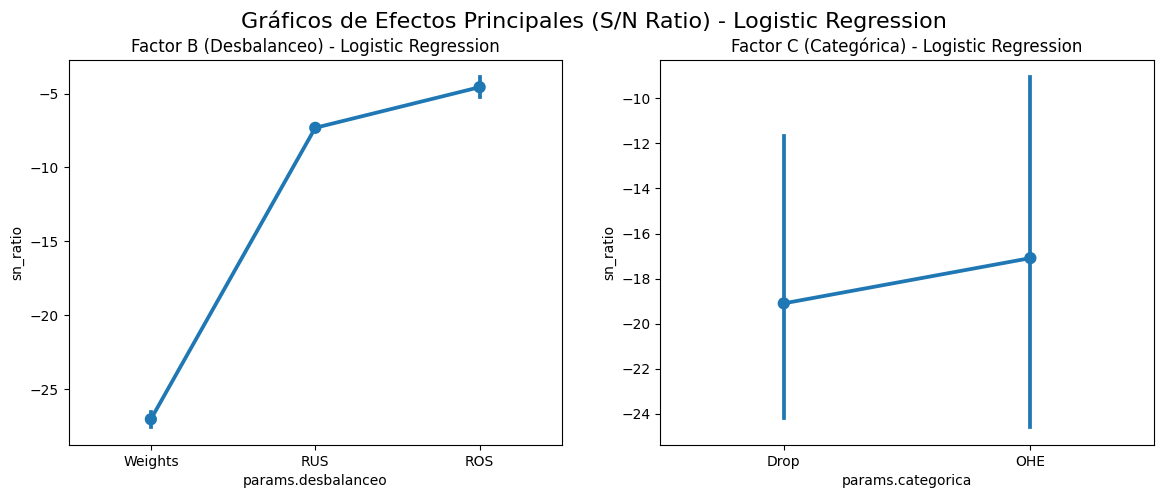


Campeón Robusto A (LR): Run 9202dd49dc6b4cde95f18d1db3714b82
Configuración: B=ROS, C=OHE


In [17]:
# 2. Análisis Torneo A (LR)
print("\n--- Resultados Torneo LR ---")
df_lr = results_df[results_df["params.modelo"] == "LR"]
if not df_lr.empty:
    # Ordenar y mostrar
    print(df_lr[["sn_ratio", "params.desbalanceo", "params.categorica"]].sort_values("sn_ratio", ascending=False).to_markdown(index=False))
    plot_efectos(df_lr, "Logistic Regression")

    # Identificar Campeón A
    campeon_a_run = df_lr.loc[df_lr['sn_ratio'].idxmax()]
    print(f"\nCampeón Robusto A (LR): Run {campeon_a_run['run_id']}")
    print(f"Configuración: B={campeon_a_run['params.desbalanceo']}, C={campeon_a_run['params.categorica']}")
else:
    print("No se encontraron resultados para LR.")



--- Resultados Torneo GBT ---
|   sn_ratio | params.desbalanceo   | params.categorica   |
|-----------:|:---------------------|:--------------------|
|   -1.1609  | ROS                  | OHE                 |
|   -3.37804 | ROS                  | Drop                |
|   -7.17625 | RUS                  | Drop                |
|   -7.60901 | RUS                  | OHE                 |
|  -27.5139  | Weights              | OHE                 |
|  -28.8116  | Weights              | Drop                |
|  -29.3359  | Weights              | Drop                |


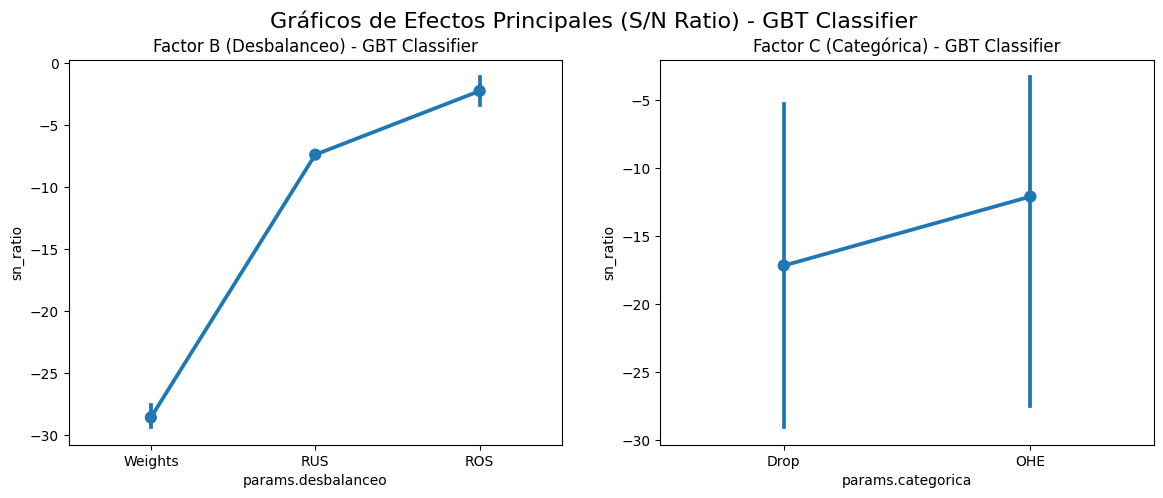


Campeón Robusto B (GBT): Run 912e271578124eeab291d6f91bc0ef7c
Configuración: B=ROS, C=OHE


In [18]:
# 3. Análisis Torneo B (GBT)
print("\n--- Resultados Torneo GBT ---")
df_gbt = results_df[results_df["params.modelo"] == "GBT"]
if not df_gbt.empty:
    print(df_gbt[["sn_ratio", "params.desbalanceo", "params.categorica"]].sort_values("sn_ratio", ascending=False).to_markdown(index=False))
    plot_efectos(df_gbt, "GBT Classifier")

    campeon_b_run = df_gbt.loc[df_gbt['sn_ratio'].idxmax()]
    print(f"\nCampeón Robusto B (GBT): Run {campeon_b_run['run_id']}")
    print(f"Configuración: B={campeon_b_run['params.desbalanceo']}, C={campeon_b_run['params.categorica']}")
else:
    print("No se encontraron resultados para GBT.")



In [39]:
# --- EJECUTAR FASE 5 (CORREGIDA: Lógica ROS añadida) ---
import pandas as pd
import numpy as np
import mlflow
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

print("\n--- INICIANDO FASE 5: ANÁLISIS, RE-OPTIMIZACIÓN Y DUELO FINAL ---")

# 1. Cargar resultados del experimento desde MLflow
try:
    exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    runs_df = mlflow.search_runs(experiment_ids=[exp.experiment_id])
    runs_df = runs_df[runs_df["tags.status"] == "SUCCESS"]

    cols_to_keep = [
        "run_id", "metrics.sn_ratio_lb", "params.modelo", "params.desbalanceo",
        "params.categorica", "params.maxDepth", "params.maxIter",
        "params.regParam", "params.elasticNetParam"
    ]
    cols_exist = [col for col in cols_to_keep if col in runs_df.columns]
    results_df = runs_df[cols_exist].dropna(subset=["metrics.sn_ratio_lb"])
    results_df.rename(columns={"metrics.sn_ratio_lb": "sn_ratio"}, inplace=True)
    print(f"Se cargaron {len(results_df)} corridas exitosas desde MLflow.")

except Exception as e:
    print(f"Error al cargar datos de MLflow: {e}")
    if 'df_resultados_backup' in locals() and not df_resultados_backup.empty:
        print("Usando backup de la celda anterior...")
        # Adaptar nombres si el backup es la lista 'resultados_doe' convertida a DataFrame
        if "params.modelo" not in df_resultados_backup.columns:
            results_df = df_resultados_backup.rename(columns={
                "modelo": "params.modelo",
                "desbalanceo": "params.desbalanceo",
                "categorica": "params.categorica",
            })
            # Expandir 'best_params' si existe
            if 'best_params' in results_df.columns:
                params_df = results_df['best_params'].apply(pd.Series)
                # Renombrar columnas de hiperparámetros
                params_df = params_df.rename(columns={
                    "maxDepth": "params.maxDepth", "maxIter": "params.maxIter",
                    "regParam": "params.regParam", "elasticNetParam": "params.elasticNetParam"
                })
                results_df = pd.concat([results_df.drop('best_params', axis=1), params_df], axis=1)
        else:
             results_df = df_resultados_backup

        # Añadir HPO params faltantes si aún no existen
        for col_name in ["params.regParam", "params.elasticNetParam", "params.maxDepth", "params.maxIter"]:
            if col_name not in results_df.columns: results_df[col_name] = pd.NA
    else:
        print("Error: No hay datos disponibles. Abortando.")
        results_df = pd.DataFrame()

# (Opcional: Aquí iría el código de plot_efectos y análisis de torneos A/B...)
# ... Identificar campeon_a_run y campeon_b_run ...
# Para que el código de abajo funcione, asumimos que ya identificaste los campeones:
campeon_a_run = None
campeon_b_run = None

if not results_df.empty:
    df_lr = results_df[results_df["params.modelo"] == "LR"]
    if not df_lr.empty:
        campeon_a_run = df_lr.loc[df_lr['sn_ratio'].idxmax()]
        print(f"Campeón A (LR): Run {campeon_a_run['run_id']} (S/N: {campeon_a_run['sn_ratio']:.2f})")

    df_gbt = results_df[results_df["params.modelo"] == "GBT"]
    if not df_gbt.empty:
        campeon_b_run = df_gbt.loc[df_gbt['sn_ratio'].idxmax()]
        print(f"Campeón B (GBT): Run {campeon_b_run['run_id']} (S/N: {campeon_b_run['sn_ratio']:.2f})")
else:
    print("Advertencia: No se pudieron cargar los resultados, el duelo final no se ejecutará.")


# --- 4. Duelo Final (CON RE-OPTIMIZACIÓN) ---
print("\n--- Duelo Final en Test Data ---")

# 1. Definir label_converter explícitamente (ya no viene de la función)
label_converter = col("accidente_grave").cast(DoubleType()).alias("label")

# 2. Preparar datos
training_data_final_con_label = training_data.select("*", label_converter)
test_data_final_con_label = test_data.select("*", label_converter)
training_data_final_con_label.cache()
test_data_final_con_label.cache()

def entrenar_campeon(run_info, modelo_str):
    print(f"\n--- Re-optimizando y Entrenando Modelo Final {modelo_str} ---")

    # 1. Extraer Params ESTRUCTURALES
    b_val = run_info["params.desbalanceo"]
    c_val = run_info["params.categorica"]
    print(f"   -> Configuración: Desbalanceo={b_val}, Categórica={c_val}")

    # 2. Aplicar lógica de datos (RUS / Weights / ROS) al 80% de los datos
    datos_entrenamiento_final = training_data_final_con_label

    if b_val == "RUS":
        print("   -> Aplicando RUS a los datos de entrenamiento finales...")
        major = datos_entrenamiento_final.filter(col("label") == 0)
        minor = datos_entrenamiento_final.filter(col("label") == 1)
        if major.count() > 0 and minor.count() > 0:
            ratio = (minor.count() / major.count()) * 1.1
            if ratio > 1.0: ratio = 1.0
            datos_entrenamiento_final = major.sample(False, ratio, seed=SEED).unionAll(minor)

    elif b_val == "Weights":
        print("   -> Aplicando ClassWeights a los datos de entrenamiento finales...")
        counts = datos_entrenamiento_final.groupBy("label").count().collect()
        count_0 = next((r['count'] for r in counts if r['label'] == 0.0), 0)
        count_1 = next((r['count'] for r in counts if r['label'] == 1.0), 0)
        if count_0 > 0 and count_1 > 0:
            total = count_0 + count_1
            w0 = total / (2.0 * count_0); w1 = total / (2.0 * count_1)
            datos_entrenamiento_final = datos_entrenamiento_final.withColumn(
                "classWeight", when(col("label") == 0.0, w0).otherwise(w1)
            )

    # --- INICIO DE LA CORRECCIÓN (Lógica ROS añadida) ---
    elif b_val == "ROS":
        print("   -> Aplicando ROS a los datos de entrenamiento finales...")
        major_df = datos_entrenamiento_final.filter(col("label") == 0)
        minor_df = datos_entrenamiento_final.filter(col("label") == 1)

        # Cachear para eficiencia
        major_df.cache()
        minor_df.cache()

        count_major = major_df.count()
        count_minor = minor_df.count()

        if count_major > 0 and count_minor > 0 and count_major > count_minor:
            ratio = count_major / count_minor
            print(f"   -> Ratio ROS: {ratio:.2f} (Major: {count_major}, Minor: {count_minor})")

            # Muestrear la clase minoritaria CON reemplazo
            minor_oversampled = minor_df.sample(withReplacement=True, fraction=ratio, seed=SEED)

            # Unir la clase mayoritaria original con la minoritaria sobremuestreada
            datos_entrenamiento_final = major_df.unionAll(minor_oversampled)
            print(f"   -> ROS Aplicado. Nuevo tamaño: {datos_entrenamiento_final.count()}")

        elif count_minor == 0:
            print("   -> ADVERTENCIA: ROS omitido (no hay muestras de clase minoritaria).")
        elif count_major == 0:
             print("   -> ADVERTENCIA: ROS omitido (no hay muestras de clase mayoritaria).")
        else: # count_major <= count_minor
             print(f"   -> INFO: ROS omitido (datos ya balanceados o minoría > mayoría).")

        # Limpiar cache
        major_df.unpersist()
        minor_df.unpersist()
    # --- FIN DE LA CORRECCIÓN ---

    # 3. Construir Pipeline (Solo devuelve 2 valores ahora)
    # (Asume que construir_pipeline y ejecutar_hpo están definidas en celdas anteriores)
    pipeline, model_instance = construir_pipeline(modelo_str, b_val, c_val)

    # 4. ETAPA DE RE-OPTIMIZACIÓN
    # (Nota: Asegúrate de que ejecutar_hpo esté usando el n_trials deseado para la re-optimización,
    # por ejemplo 5 trials, en lugar de los 3 de la fase 4)
    print(f"   -> Ejecutando RE-OPTIMIZACIÓN (usando n_trials={10}) para {modelo_str}...")
    try:
        best_params_dict_str_keys = ejecutar_hpo(spark, datos_entrenamiento_final, pipeline, model_instance, modelo_str, trials = 10)
        final_best_params = best_params_dict_str_keys # Ya devuelve {str: val}

        print(f"   -> Parámetros finales óptimos encontrados: {final_best_params}")
    except Exception as e:
        print(f"   -> ADVERTENCIA: Re-optimización falló ({e}). Usando defaults.")
        final_best_params = {}

    # 5. Entrenar Modelo Final
    # Re-construir el pipeline final y setear los params encontrados
    pipeline_final, _ = construir_pipeline(modelo_str, b_val, c_val)

    # Setear params dinámicamente
    if final_best_params:
        try:
            # Iterar sobre los {str: val}
            for p_name, p_val in final_best_params.items():
                 # Buscar el parámetro en el objeto del modelo por nombre
                 if pipeline_final.getStages()[-1].hasParam(p_name):
                     spark_param = pipeline_final.getStages()[-1].getParam(p_name)
                     pipeline_final.getStages()[-1].set(spark_param, p_val)
            print("   -> Hiperparámetros óptimos aplicados.")
        except Exception as e:
            print(f"   -> Advertencia al setear hiperparámetros: {e}. Usando defaults.")

    print(f"   -> Entrenando modelo final {modelo_str} en {datos_entrenamiento_final.count()} filas...")
    model = pipeline_final.fit(datos_entrenamiento_final)
    return model

# Entrenar A
modelo_final_a = None
if campeon_a_run is not None:
    modelo_final_a = entrenar_campeon(campeon_a_run, "LR")
else:
    print("No se encontró campeón A (LR). Omitiendo entrenamiento.")

# Entrenar B
modelo_final_b = None
if campeon_b_run is not None:
    modelo_final_b = entrenar_campeon(campeon_b_run, "GBT")
else:
    print("No se encontró campeón B (GBT). Omitiendo entrenamiento.")


# 5. Evaluación
print("\n--- Evaluación en Test Data ---")
eval_pr = BinaryClassificationEvaluator(metricName="areaUnderPR", labelCol="label")
eval_rec = MulticlassClassificationEvaluator(metricName="recallByLabel", metricLabel=1.0, labelCol="label")

auc_a, rec_a = 0.0, 0.0
preds_a = None
if modelo_final_a:
    preds_a = modelo_final_a.transform(test_data_final_con_label)
    auc_a = eval_pr.evaluate(preds_a)
    rec_a = eval_rec.evaluate(preds_a)
    print(f"Modelo A (LR): AUC-PR={auc_a:.4f}, Recall(1)={rec_a:.4f}")

auc_b, rec_b = 0.0, 0.0
preds_b = None
if modelo_final_b:
    preds_b = modelo_final_b.transform(test_data_final_con_label)
    auc_b = eval_pr.evaluate(preds_b)
    rec_b = eval_rec.evaluate(preds_b)
    print(f"Modelo B (GBT): AUC-PR={auc_b:.4f}, Recall(1)={rec_b:.4f}")

# 6. Matriz de Confusión y Ganador
ganador_preds = None
nombre_ganador = "N/A"
sn_ganador = 0.0

if auc_b > auc_a:
    ganador_preds = preds_b
    nombre_ganador = "GBT Classifier"
    if campeon_b_run is not None: sn_ganador = campeon_b_run['sn_ratio']
elif auc_a > 0.0: # Solo gana A si es mejor que B, o si B falló (auc_b=0)
    ganador_preds = preds_a
    nombre_ganador = "Logistic Regression"
    if campeon_a_run is not None: sn_ganador = campeon_a_run['sn_ratio']

if ganador_preds:
    print(f"\n--- Matriz de Confusión ({nombre_ganador}) ---")
    rdd_preds = ganador_preds.select("prediction", "label").rdd.map(lambda r: (float(r.prediction), float(r.label)))
    metrics = MulticlassMetrics(rdd_preds)
    print(metrics.confusionMatrix().toArray())

    print("\n--- CONCLUSIÓN FINAL ---")
    print(f"El modelo ganador es: {nombre_ganador}")
    print(f"Justificación: Demostró la arquitectura más robusta en el diseño experimental (S/N Ratio: {sn_ganador:.2f})")
    print(f"y confirmó su superioridad en datos nunca vistos (Test Data) con un AUC-PR de {max(auc_a, auc_b):.4f}.")
else:
    print("\nNo se pudo determinar un modelo ganador (Ambos modelos fallaron o no entrenaron).")

# 7. Limpiar cache
training_data_final_con_label.unpersist()
test_data_final_con_label.unpersist()
print("\n--- FASE 5 COMPLETADA ---")


--- INICIANDO FASE 5: ANÁLISIS, RE-OPTIMIZACIÓN Y DUELO FINAL ---
Se cargaron 21 corridas exitosas desde MLflow.
Campeón A (LR): Run 9202dd49dc6b4cde95f18d1db3714b82 (S/N: -3.90)
Campeón B (GBT): Run 912e271578124eeab291d6f91bc0ef7c (S/N: -1.16)

--- Duelo Final en Test Data ---

--- Re-optimizando y Entrenando Modelo Final LR ---
   -> Configuración: Desbalanceo=ROS, Categórica=OHE
   -> Aplicando ROS a los datos de entrenamiento finales...


[I 2025-11-17 22:45:38,928] A new study created in memory with name: no-name-b8f170bd-b3d6-48be-b00b-813c0e364163


   -> Ratio ROS: 27.29 (Major: 3575, Minor: 131)
   -> ROS Aplicado. Nuevo tamaño: 7101
   -> Ejecutando RE-OPTIMIZACIÓN (usando n_trials=10) para LR...


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-11-17 22:45:52,576] Trial 0 finished with value: 0.6384176472949985 and parameters: {'regParam': 0.00184837471225591, 'elasticNetParam': 0.357597879783649}. Best is trial 0 with value: 0.6384176472949985.
[I 2025-11-17 22:46:11,293] Trial 1 finished with value: 0.6210191457554431 and parameters: {'regParam': 0.02979878755769156, 'elasticNetParam': 0.5917334304203362}. Best is trial 0 with value: 0.6384176472949985.
[I 2025-11-17 22:46:19,527] Trial 2 finished with value: 0.6364

   -> Parámetros finales óptimos encontrados: {'regParam': 0.00184837471225591, 'elasticNetParam': 0.357597879783649}
   -> Hiperparámetros óptimos aplicados.
   -> Entrenando modelo final LR en 7101 filas...


[I 2025-11-17 22:47:29,720] A new study created in memory with name: no-name-c3861f39-536f-4f5a-aee6-4d8086cd9f87



--- Re-optimizando y Entrenando Modelo Final GBT ---
   -> Configuración: Desbalanceo=ROS, Categórica=OHE
   -> Aplicando ROS a los datos de entrenamiento finales...
   -> Ratio ROS: 27.29 (Major: 3575, Minor: 131)
   -> ROS Aplicado. Nuevo tamaño: 7101
   -> Ejecutando RE-OPTIMIZACIÓN (usando n_trials=10) para GBT...


[I 2025-11-17 22:47:40,761] Trial 0 finished with value: 0.6572917523589319 and parameters: {'maxDepth': 2, 'maxIter': 12}. Best is trial 0 with value: 0.6572917523589319.
[I 2025-11-17 22:48:07,028] Trial 1 finished with value: 0.8831102480222977 and parameters: {'maxDepth': 6, 'maxIter': 21}. Best is trial 1 with value: 0.8831102480222977.
[I 2025-11-17 22:48:27,286] Trial 2 finished with value: 0.8525046244614306 and parameters: {'maxDepth': 5, 'maxIter': 19}. Best is trial 1 with value: 0.8831102480222977.
[I 2025-11-17 22:48:41,465] Trial 3 finished with value: 0.7044248260235575 and parameters: {'maxDepth': 3, 'maxIter': 13}. Best is trial 1 with value: 0.8831102480222977.
[I 2025-11-17 22:48:52,214] Trial 4 finished with value: 0.8123656253122126 and parameters: {'maxDepth': 5, 'maxIter': 10}. Best is trial 1 with value: 0.8831102480222977.
[I 2025-11-17 22:49:02,537] Trial 5 finished with value: 0.6583696835111726 and parameters: {'maxDepth': 2, 'maxIter': 15}. Best is trial 1 

   -> Parámetros finales óptimos encontrados: {'maxDepth': 6, 'maxIter': 23}
   -> Hiperparámetros óptimos aplicados.
   -> Entrenando modelo final GBT en 7101 filas...

--- Evaluación en Test Data ---
Modelo A (LR): AUC-PR=0.0378, Recall(1)=0.6897
Modelo B (GBT): AUC-PR=0.0351, Recall(1)=0.2414

--- Matriz de Confusión (Logistic Regression) ---
[[500. 412.]
 [  9.  20.]]

--- CONCLUSIÓN FINAL ---
El modelo ganador es: Logistic Regression
Justificación: Demostró la arquitectura más robusta en el diseño experimental (S/N Ratio: -3.90)
y confirmó su superioridad en datos nunca vistos (Test Data) con un AUC-PR de 0.0378.

--- FASE 5 COMPLETADA ---


/usr/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


# 7. Conclusión Final

In [43]:

print("\n--- Conclusión Final ---")
if 'campeon_a_run' not in locals() and 'campeon_b_run' not in locals():
    print("No se completaron las ejecuciones para determinar un ganador.")
elif 'campeon_b_run' in locals() and auc_b > auc_a:
    print("El modelo GBT Classifier es el ganador.")
    print(f"Justificación: Demostró la arquitectura más robusta (S/N Ratio: {campeon_b_run['sn_ratio']:.2f}) en el DOE \n y logró el mejor rendimiento (AUC-PR: {auc_b:.4f}) en el Test Data final.")
elif 'campeon_a_run' in locals():
    print("El modelo Logistic Regression es el ganador.")
    print(f"Justificación: Demostró la arquitectura más robusta (S/N Ratio: {campeon_a_run['sn_ratio']:.2f}) en el DOE \n y logró el mejor rendimiento (AUC-PR: {auc_a:.4f}) en el Test Data final.")
else:
     print("No se pudo determinar un ganador (revisar ejecuciones).")


--- Conclusión Final ---
El modelo Logistic Regression es el ganador.
Justificación: Demostró la arquitectura más robusta (S/N Ratio: -3.90) en el DOE 
 y logró el mejor rendimiento (AUC-PR: 0.0378) en el Test Data final.
